<a href="https://colab.research.google.com/github/fachiappetta/BassConnections2022-2023/blob/main/Copy_of_linear_regression_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [51]:
!pip install d2l==1.0.0-alpha1.post0


In [52]:
%matplotlib inline
import torch
from d2l import torch as d2l

In [ ]:
class LinearRegressionScratch(d2l.Module):  #@save
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

    def plot(self, key, value, train):
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'Epoch'
        self.board.ylabel = 'Loss'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('Training ' if train else 'Validation ') + key,
                        every_n=int(n))




    

In [ ]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    """The linear regression model."""
    return torch.matmul(X, self.w) + self.b

In [ ]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
    return l.mean()

In [ ]:
class SGD(d2l.HyperParameters):  #@save
    def __init__(self, params, lr):
        """Minibatch stochastic gradient descent."""
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [ ]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

In [ ]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

In [ ]:
@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

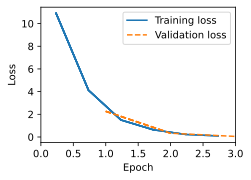

In [ ]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)




Because we synthesized the dataset ourselves,
we know precisely what the true parameters are.
Thus, we can [**evaluate our success in training
by comparing the true parameters
with those that we learned**] through our training loop.
Indeed they turn out to be very close to each other.


In [ ]:
print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.0774, -0.2105], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.2131], grad_fn=<RsubBackward1>)


We should not take the ability to exactly recover 
the ground-truth parameters for granted.
In general, for deep models unique solutions
for the parameters do not exist,
and even for linear models,
exactly recovering the parameters
is only possible when no feature 
is linearly dependent on the others.
However, in machine learning, 
we are often less concerned
with recovering true underlying parameters,
and more concerned with parameters 
that lead to highly accurate prediction :cite:`Vapnik.1992`.
Fortunately, even on difficult optimization problems,
stochastic gradient descent can often find remarkably good solutions,
owing partly to the fact that, for deep networks,
there exist many configurations of the parameters
that lead to highly accurate prediction.


## Summary

In this section, we took a significant step 
towards designing deep learning systems 
by implementing a fully functional 
neural network model and training loop.
In this process, we built a data loader, 
a model, a loss function, an optimization procedure,
and a visualization and monitoring tool. 
We did this by composing a Python object 
that contains all relevant components for training a model. 
While this is not yet a professional-grade implementation
it is perfectly functional and code like this 
could already help you to solve small problems quickly.
In the next sections, we will see how to do this
both *more concisely* (avoiding boilerplate code)
and *more efficiently* (use our GPUs to their full potential).



## Exercises

1. What would happen if we were to initialize the weights to zero. Would the algorithm still work? What if we
   initialized the parameters with variance $1,000$ rather than $0.01$?
1. Assume that you are [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm) trying to come up
   with a model for resistors that relate voltage and current. Can you use automatic
   differentiation to learn the parameters of your model?
1. Can you use [Planck's Law](https://en.wikipedia.org/wiki/Planck%27s_law) to determine the temperature of an object
   using spectral energy density? For reference, the spectral density $B$ of radiation emanating from a black body is
   $B(\lambda, T) = \frac{2 hc^2}{\lambda^5} \cdot \left(\exp \frac{h c}{\lambda k T} - 1\right)^{-1}$. Here
   $\lambda$ is the wavelength, $T$ is the temperature, $c$ is the speed of light, $h$ is Planck's quantum, and $k$ is the
   Boltzmann constant. You measure the energy for different wavelengths $\lambda$ and you now need to fit the spectral
   density curve to Planck's law.
1. What are the problems you might encounter if you wanted to compute the second derivatives of the loss? How would
   you fix them?
1. Why is the `reshape` method needed in the `loss` function?
1. Experiment using different learning rates to find out how quickly the loss function value drops. Can you reduce the
   error by increasing the number of epochs of training?
1. If the number of examples cannot be divided by the batch size, what happens to `data_iter` at the end of an epoch?
1. Try implementing a different loss function, such as the absolute value loss `(y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()`.
    1. Check what happens for regular data.
    1. Check whether there is a difference in behavior if you actively perturb some entries of $\mathbf{y}$,
       such as $y_5 = 10,000$.
    1. Can you think of a cheap solution for combining the best aspects of squared loss and absolute value loss?
       Hint: how can you avoid really large gradient values?
1. Why do we need to reshuffle the dataset? Can you design a case where a maliciously dataset would break the
   optimization algorithm otherwise?


[Discussions](https://discuss.d2l.ai/t/43)
